Saved: figures/figure4_scatter_outliers.png
Saved: figures/figure5_state_risk_bar.png (or choropleth if GeoJSON)
Saved: figures/figure6_volume_distribution.png
Saved: figures/figure7_correlation_heatmap.png


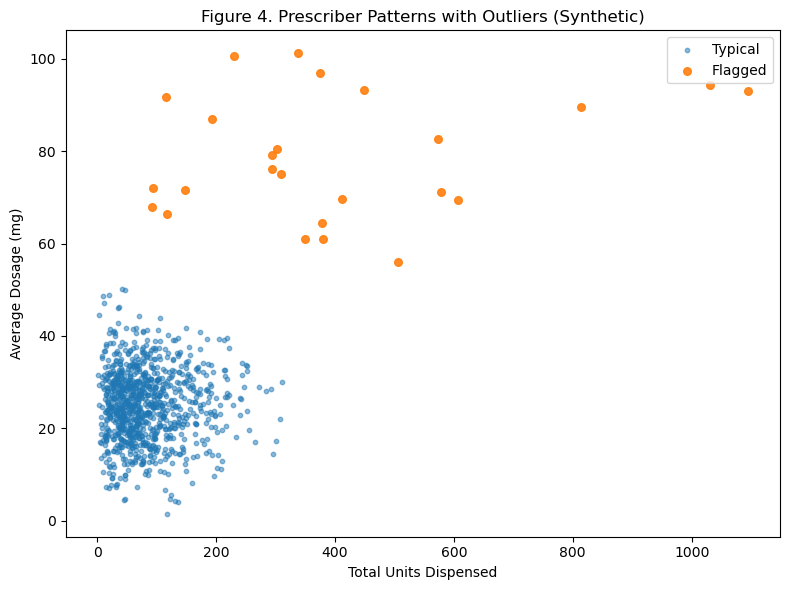

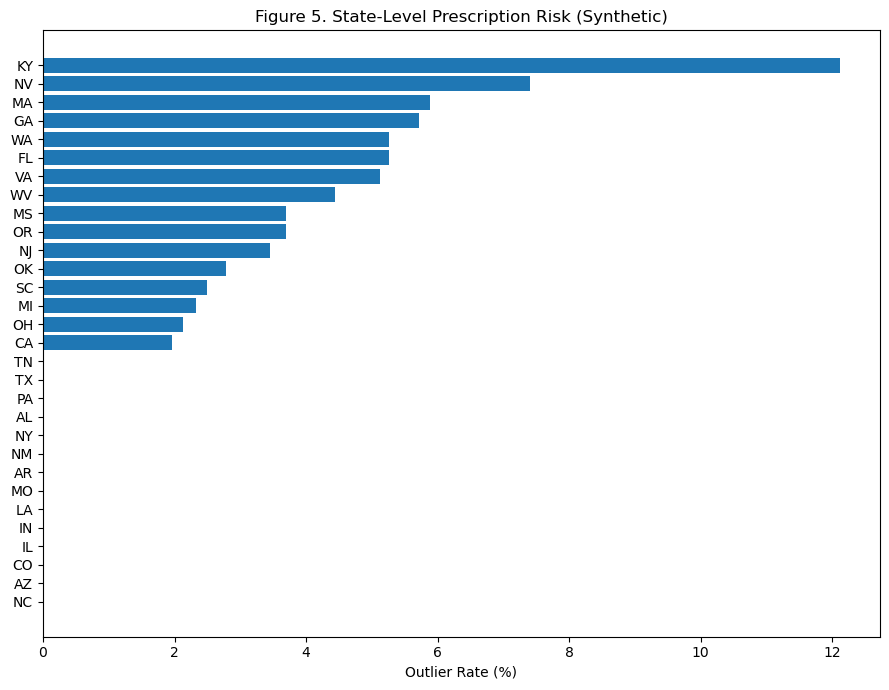

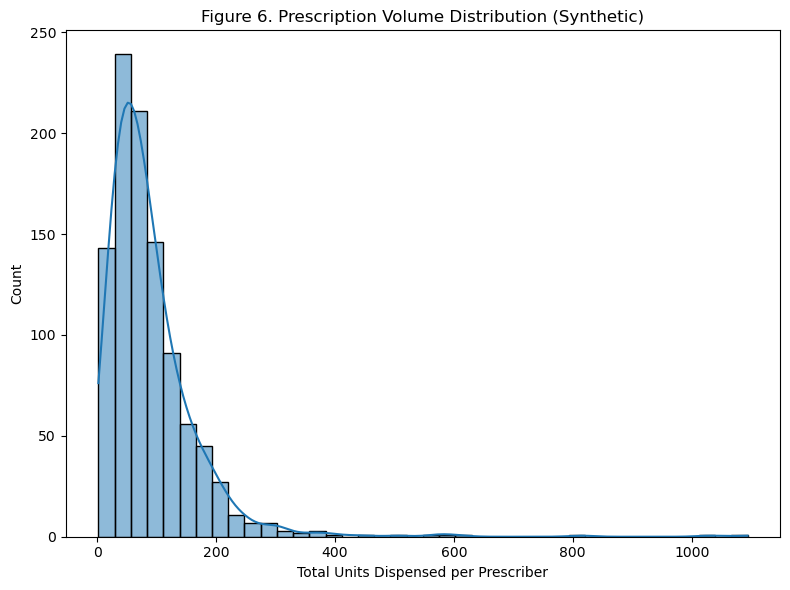

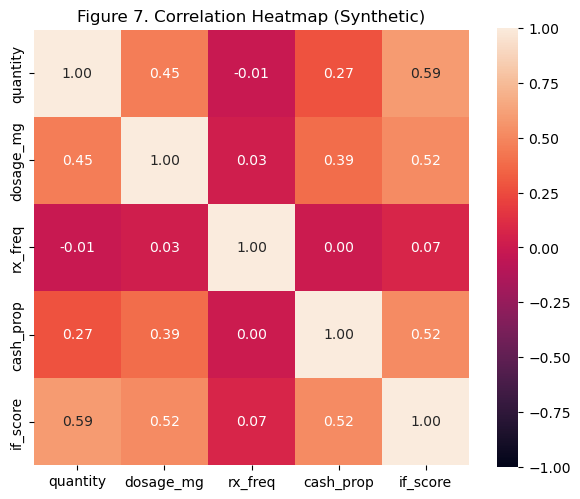

In [1]:
# === environment: python 3.10+, packages: numpy, pandas, scikit-learn, matplotlib, seaborn (optional), plotly (optional) ===
import os, json, numpy as np, pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns  # only for corr heatmap aesthetics

np.random.seed(42)
os.makedirs("figures", exist_ok=True)

# -----------------------------
# 1) S Y N T H E T I C   D A T A
# -----------------------------
n = 1000
states = ["FL","OH","WV","KY","TN","AL","GA","PA","MI","NC","SC","VA","IN","IL","TX","CA","NY","NJ","MA","AZ","CO","WA","OR","NV","LA","MS","MO","OK","AR","NM"]
prescriber_id = [f"P{str(i).zfill(5)}" for i in range(n)]
base_qty = np.random.gamma(shape=2.0, scale=40.0, size=n)                    # total units dispensed
avg_dose = np.random.normal(loc=25, scale=8, size=n).clip(1, 160)            # mg
rx_freq  = np.random.poisson(lam=20, size=n)                                 # prescriptions count
cash_prop = np.random.beta(2, 10, size=n)                                    # share paid cash
state = np.random.choice(states, size=n, p=np.array(
    [0.05,0.05,0.045,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.045,0.045,0.045,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02]
)/np.sum([0.05,0.05,0.045,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.045,0.045,0.045,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02]))

# inject a few outliers (higher qty & dose, more cash payments)
k = 25
out_idx = np.random.choice(n, k, replace=False)
base_qty[out_idx] *= np.random.uniform(3, 6, size=k)
avg_dose[out_idx] += np.random.uniform(30, 80, size=k)
cash_prop[out_idx] = np.clip(cash_prop[out_idx] + np.random.uniform(0.3, 0.6, size=k), 0, 1)

df = pd.DataFrame({
    "prescriber_id": prescriber_id,
    "state": state,
    "quantity": base_qty,
    "dosage_mg": avg_dose,
    "rx_freq": rx_freq,
    "cash_prop": cash_prop
})

# create a simple time series for volume distribution
months = pd.date_range("2023-01-01", "2023-12-01", freq="MS")
ts = (pd.DataFrame({"month": np.repeat(months, n),
                    "prescriber_id": np.tile(df["prescriber_id"], len(months))})
      .merge(df[["prescriber_id","quantity","dosage_mg"]], on="prescriber_id", how="left"))
# seasonality + noise
month_effect = {m: 1.0 + 0.25*np.sin(2*np.pi*(i/12)) for i,m in enumerate(months)}
ts["vol"] = (ts["quantity"]*0.3*np.random.uniform(0.7,1.3,len(ts))
             * ts["month"].map(month_effect).values)

# -----------------------------
# 2) I S O L A T I O N   F O R E S T
# -----------------------------
feats = ["quantity","dosage_mg","rx_freq","cash_prop"]
X = df[feats].copy()
X_scaled = StandardScaler().fit_transform(X)
iso = IsolationForest(n_estimators=300, contamination=0.025, random_state=42)
df["anomaly_score"] = -iso.fit_predict(X_scaled)  # 2 for outlier, 0 for inlier after mapping below
# convert to 1/0 flags and keep raw decision_function
df["if_score"] = -iso.decision_function(X_scaled)  # higher = more anomalous
df["is_outlier"] = (df["if_score"] >= np.quantile(df["if_score"], 0.975)).astype(int)

# -----------------------------
# FIG 4: Scatter (quantity vs dosage), highlight outliers
# -----------------------------
plt.figure(figsize=(8,6))
inl = df["is_outlier"]==0
out = df["is_outlier"]==1
plt.scatter(df.loc[inl,"quantity"], df.loc[inl,"dosage_mg"], s=10, alpha=0.5, label="Typical")
plt.scatter(df.loc[out,"quantity"], df.loc[out,"dosage_mg"], s=30, alpha=0.9, label="Flagged")
plt.xlabel("Total Units Dispensed")
plt.ylabel("Average Dosage (mg)")
plt.title("Figure 4. Prescriber Patterns with Outliers (Synthetic)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/figure4_scatter_outliers.png", dpi=300)

# -----------------------------
# FIG 5: U.S. hotspots (state-level) as a quick bar “heatmap” fallback
# (robust if you don’t have a states GeoJSON handy)
# -----------------------------
state_risk = (df.groupby("state")
                .agg(vol=("quantity","sum"), risk=("is_outlier","mean"))
                .reset_index())
state_risk["risk_index"] = (state_risk["risk"]*100).round(2)

# Sort by risk for a clear bar chart
top = state_risk.sort_values("risk", ascending=False)

plt.figure(figsize=(9,7))
plt.barh(top["state"], top["risk_index"])
plt.gca().invert_yaxis()
plt.xlabel("Outlier Rate (%)")
plt.title("Figure 5. State-Level Prescription Risk (Synthetic)")
plt.tight_layout()
plt.savefig("figures/figure5_state_risk_bar.png", dpi=300)

# If you DO have a US states GeoJSON, you can build a choropleth with Plotly:
# import plotly.express as px, json
# with open("path/to/us_states.geojson","r") as f:
#     us_geo = json.load(f)
# fig = px.choropleth(state_risk, geojson=us_geo, locations="state", featureidkey="properties.STUSPS",
#                     color="risk_index", scope="usa",
#                     color_continuous_scale="Reds", labels={"risk_index":"Outlier Rate (%)"},
#                     title="Figure 5. Synthetic U.S. Hotspots")
# fig.write_image("figures/figure5_state_risk_map.png")

# -----------------------------
# FIG 6: Prescription volume distribution (hist + KDE)
# -----------------------------
plt.figure(figsize=(8,6))
vals = df["quantity"]
sns.histplot(vals, bins=40, kde=True)
plt.xlabel("Total Units Dispensed per Prescriber")
plt.ylabel("Count")
plt.title("Figure 6. Prescription Volume Distribution (Synthetic)")
plt.tight_layout()
plt.savefig("figures/figure6_volume_distribution.png", dpi=300)

# -----------------------------
# FIG 7: Correlation heatmap
# -----------------------------
plt.figure(figsize=(6,5))
corr = df[["quantity","dosage_mg","rx_freq","cash_prop","if_score"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, square=True)
plt.title("Figure 7. Correlation Heatmap (Synthetic)")
plt.tight_layout()
plt.savefig("figures/figure7_correlation_heatmap.png", dpi=300)

print("Saved: figures/figure4_scatter_outliers.png")
print("Saved: figures/figure5_state_risk_bar.png (or choropleth if GeoJSON)")
print("Saved: figures/figure6_volume_distribution.png")
print("Saved: figures/figure7_correlation_heatmap.png")
